In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import scipy
from numba import njit, jit
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import signal
from functools import partial
from skimage.transform import rescale

# how to get context
* feed in downdsampled whole image with subsample - put at layer in 3dcnn, make a fork with subsample and downsample at top
* physics things
* 3 frame thing - would need to stabalize video
* get vector field, get most common vector, use that as an input

# things to try:
* put a residual connection from the output of the first conv's to the 2nd to last layer

In [2]:
from IPython.display import Audio, display

url_exception = "http://www.wav-sounds.com/movie/austinpowers.wav"
url_exception = "https://www.myinstants.com/media/sounds/roblox-death-sound_1.mp3"


def play_sound(self, etype, value, tb, tb_offset=None):
    self.showtraceback((etype, value, tb), tb_offset=tb_offset)
    display(Audio(url=url_exception, autoplay=True))


get_ipython().set_custom_exc((Exception,), play_sound)

url_done = (
    "https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav"
)
url_done = "https://www.myinstants.com/media/sounds/taco-bell-bong-sfx.mp3"
url_done = "https://www.myinstants.com/media/sounds/magic_immune.mp3"


def allDone():
    display(Audio(url=url_done, autoplay=True,))

In [3]:
data_dir = os.path.join(os.getcwd(), "data")
pavel_dir = os.path.join(data_dir, "pavel_data")

In [4]:
video_files = ["processed_video_" + str(i) + ".npy" for i in range(4)]
label_files = ["label_" + str(i) + ".npy" for i in range(4)]

videos = []
label_np = []
for video_file, label_file in zip(video_files, label_files):
    videos.append(np.load(os.path.join(pavel_dir, video_file)).astype("float32"))
    label_np.append(np.load(os.path.join(pavel_dir, label_file)).astype("float32"))

In [5]:
output_size = 20

In [6]:
print(videos[0].shape)

(1144, 218, 248)


In [7]:
# video = np.stack(np.atleast_3d(*video), axis=0)


def add_axis_to_frames(a):
    a = np.stack(np.atleast_3d(*a), axis=0)
    return a


videos = list(map(add_axis_to_frames, videos))

# ways to shape the data:
* one big list for everything
* 3d video chunks with a few consecutive frames

In [8]:
clockwise_90 = np.array([[0, 1], [-1, 0]])


def apply_to_outer_axis(a, func, args=[]):
    b = a
    for i in range(len(b)):
        b[i] = func(b[i], *args)
    return b


def rotate_90(arr):
    return arr @ clockwise_90


label_np = apply_to_outer_axis(label_np, rotate_90)

In [9]:
window_size = 2


def remove_window_head(x, window_size):
    return x[window_size - 1 :]


def get_sub_videos(video, window_size):
    a = np.lib.stride_tricks.sliding_window_view(video, window_size, axis=0)
    return np.moveaxis(a, 4, 1)


label_np = apply_to_outer_axis(label_np, remove_window_head, [window_size])
videos = apply_to_outer_axis(videos, get_sub_videos, [window_size])

In [10]:
# one big list
video = np.concatenate(videos, axis=0)
labels = np.concatenate(label_np, axis=0)

In [11]:
print(video.shape, labels.shape)

(4083, 2, 218, 248, 1) (4083, 2)


# 3d conv net making things
* take stacks of 3 with a stride of 1
* take the average of the labels
* stick them together onto a new axis
* stick all of the threes together

In [12]:
from numpy.random import default_rng


def shuffle_arrays(a, b):
    assert a.shape[0] == b.shape[0]
    length = a.shape[0]
    x = a
    y = b
    rng = default_rng()
    idx = rng.choice(length, length)
    x = x[idx]
    y = y[idx]
    return x, y


def chunk_idx_shuffle(a, blocksize):
    idx = np.arange(a.shape[0])
    blocks = [
        idx[i * blocksize : (i + 1) * blocksize] for i in range(len(idx) // blocksize)
    ]
    random.shuffle(blocks)
    return [elt for block in blocks for elt in block]


def shuffle_chunks_arrays(a, b, chunk_size):
    assert a.shape[0] == b.shape[0]
    idx = chunk_idx_shuffle(a, chunk_size)
    x = a
    y = b
    x = x[idx]
    y = y[idx]
    return x, y


# video, labels = shuffle_by_blocks(labels, 10)
# x_train, y_train = shuffle_arrays(x_train, y_train)
video, labels = shuffle_chunks_arrays(video, labels, 10)
# video, labels = shuffle_arrays(video, labels)

In [13]:
print(video.shape)
print(labels.shape)

(4080, 2, 218, 248, 1)
(4080, 2)


In [14]:
def train_val_test(train, val, test, X, y):
    assert train + val + test == 1
    data_len = len(X)
    train_size = int(train * data_len)
    val_size = int(val * data_len)
    test_size = int(test * data_len)

    splits = [
        (0, train_size),
        (train_size, train_size + val_size),
        (train_size + val_size, data_len),
    ]

    x_out = []
    y_out = []
    for a, b in splits:
        x_out.append(X[a:b])
        y_out.append(y[a:b])

    return (*x_out, *y_out)


x_train, x_val, x_test, y_train, y_val, y_test = train_val_test(
    0.8, 0.2, 0.0, video, labels
)

# video cropping
* make 5crop
* take subsection of video (from center)
* take the middle and the corners
* return them as a list

In [15]:
@njit
def sub_data(x, a=None, b=None, c=None, d=None):
    return x[:, :, a:b, c:d, :]


@njit
def sub_vid(x, a=None, b=None, c=None, d=None):
    return x[:, a:b, c:d, :]


@njit
def sub_pic(x, a=None, b=None, c=None, d=None):
    return x[a:b, c:d, :]


@njit
def get_frame(x, frame):
    return x[frame]


# @njit
def get_center(x, size):
    if len(x.shape) == 5:
        _, _, h, w, _ = x.shape
        func = sub_data
    elif len(x.shape) == 4:
        _, h, w, _ = x.shape
        func = sub_vid
    elif len(x.shape) == 3:
        h, w, _ = x.shape
        func = sub_pic
    else:
        raise ValueError("unsupported dims")
    hh = h // 2
    hw = w // 2
    hs = size // 2
    return func(x, hh - hs, hh + hs, hw - hs, hw + hs)


@njit
def five_crop(frame, macro, micro):
    h, w, _ = frame.shape
    hh = h // 2
    hw = w // 2
    h_macro = macro // 2
    frame = frame[hh - h_macro : hh + h_macro, hw - h_macro : hw + h_macro, :]
    a = frame[:micro, :micro, :]
    b = frame[macro - micro :, :micro, :]
    c = frame[:micro, macro - micro :, :]
    d = frame[macro - micro :, macro - micro :, :]
    e = frame[macro - micro : macro + micro, macro - micro : macro + micro, :]
    return [a, b, c, d, e]


@njit
def random_subcrops(frame, macro, micro, num):
    for x in frame.shape[1:2]:
        assert x > macro
    assert micro <= macro
    _, h, w, _ = frame.shape
    hh = h // 2
    hw = w // 2
    h_micro = micro // 2
    h_macro = macro // 2

    h_max = hh + h_macro - h_micro
    h_min = hh - h_macro + h_micro
    w_max = hw + h_macro - h_micro
    w_min = hw - h_macro + h_micro

    sub_frames = []
    for _ in range(num):
        h = int(random.uniform(h_min, h_max))
        w = int(random.uniform(w_min, w_max))
        sub_frame = sub_vid(frame, h - h_micro, h + h_micro, w - h_micro, w + h_micro)
        sub_frames.append(sub_frame)
    return sub_frames


@njit
def random_flip(a, b):
    x, y = a, b
    r = random.random()
    if r < 0.25:
        pass
    elif r >= 0.25 and r < 0.5:
        x = x[:, ::-1, :, :]
        y = y * np.array([-1, 1])
    elif r >= 0.5 and r < 0.75:
        x = x[:, :, ::-1, :]
        y = y * np.array([-1, 1])
    elif r >= 0.75:
        x = x[:, ::-1, ::-1, :]
        y = y * np.array([-1, -1])
    return (x, y)


def data_generator(a, b, macro_size, num_resample):
    x, y = a, b
    for i, frame in enumerate(x):
        macro = get_frame(x[i], window_size - 1)
        macro = get_center(macro, macro_size)

        crops = random_subcrops(frame, 40, output_size, num_resample)
        for crop in crops:
            micro, label = random_flip(crop, y[i])

            micro = tf.convert_to_tensor(micro, dtype=tf.float32)
            macro = tf.convert_to_tensor(macro, dtype=tf.float32)
            label = tf.convert_to_tensor(label, dtype=tf.float32)

            yield {"micro": micro, "macro": macro}, label


def get_dataset(x, y):
    return tf.data.Dataset.from_generator(
        data_generator,
        args=[x_train, y_train, macro_size, num_resample],
        output_signature=(
            {
                "micro": tf.TensorSpec(shape=micro_shape, dtype=tf.float32),
                "macro": tf.TensorSpec(shape=macro_shape, dtype=tf.float32),
            },
            tf.TensorSpec(shape=label_shape, dtype=tf.float32),
        ),
    )


num_resample = 30
macro_size = 200
micro_shape = (window_size, output_size, output_size, 1)
macro_shape = (macro_size, macro_size, 1)
label_shape = (2,)

train_dataset = get_dataset(x_train, y_train)
val_dataset = get_dataset(x_val, y_val)
test_dataset = get_dataset(x_test, y_test)

In [16]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [17]:
tf.random.set_seed(1234)

In [18]:
drop_rate = 0.2
batch_size = 64
print(micro_shape)
print(macro_shape)

micro_input = tf.keras.Input(shape=micro_shape, name="micro")
macro_input = tf.keras.Input(shape=macro_shape, name="macro")

micro = micro_input
macro = macro_input

micro = tf.keras.layers.BatchNormalization()(micro)
micro = tf.keras.layers.ConvLSTM2D(
    30, 6, activation="relu", dropout=drop_rate, padding="same", return_sequences=True,
)(micro)
micro = tf.keras.layers.MaxPooling3D(pool_size=2)(micro)
micro = tf.keras.layers.BatchNormalization()(micro)
micro_early = micro  # residual
micro = tf.keras.layers.ConvLSTM2D(
    30, 6, activation="relu", dropout=drop_rate, padding="same",
)(micro)
micro = tf.keras.layers.MaxPooling2D(pool_size=2)(micro)
micro = tf.keras.layers.BatchNormalization()(micro)
micro = tf.keras.layers.Flatten()(micro)

macro = tf.keras.layers.BatchNormalization()(macro)
macro = tf.keras.layers.Conv2D(30, 20, strides=5, activation="relu")(macro)
macro = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(macro)
macro = tf.keras.layers.BatchNormalization()(macro)
macro_early = macro  # residual
macro = tf.keras.layers.Conv2D(20, 5, activation="relu")(macro)
macro = tf.keras.layers.MaxPooling2D(pool_size=3)(macro)
macro = tf.keras.layers.BatchNormalization()(macro)
macro = tf.keras.layers.Flatten()(macro)


micro_early = tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2))(micro_early)
micro_early = tf.keras.layers.Flatten()(micro_early)

macro_early = tf.keras.layers.MaxPooling2D(pool_size=3)(macro_early)
macro_early = tf.keras.layers.Flatten()(macro_early)

pred = tf.keras.layers.concatenate([macro, micro])
pred = tf.keras.layers.Dense(50, activation="relu")(pred)
pred = tf.keras.layers.Dropout(drop_rate)(pred)
# pred = tf.keras.layers.concatenate([pred, macro_early, micro_early])  # residual
pred = tf.keras.layers.Dense(100, activation="relu")(pred)
pred = tf.keras.layers.Dense(2, name="output")(pred)

model = tf.keras.Model(inputs=[macro_input, micro_input], outputs=[pred],)

(2, 20, 20, 1)
(200, 200, 1)


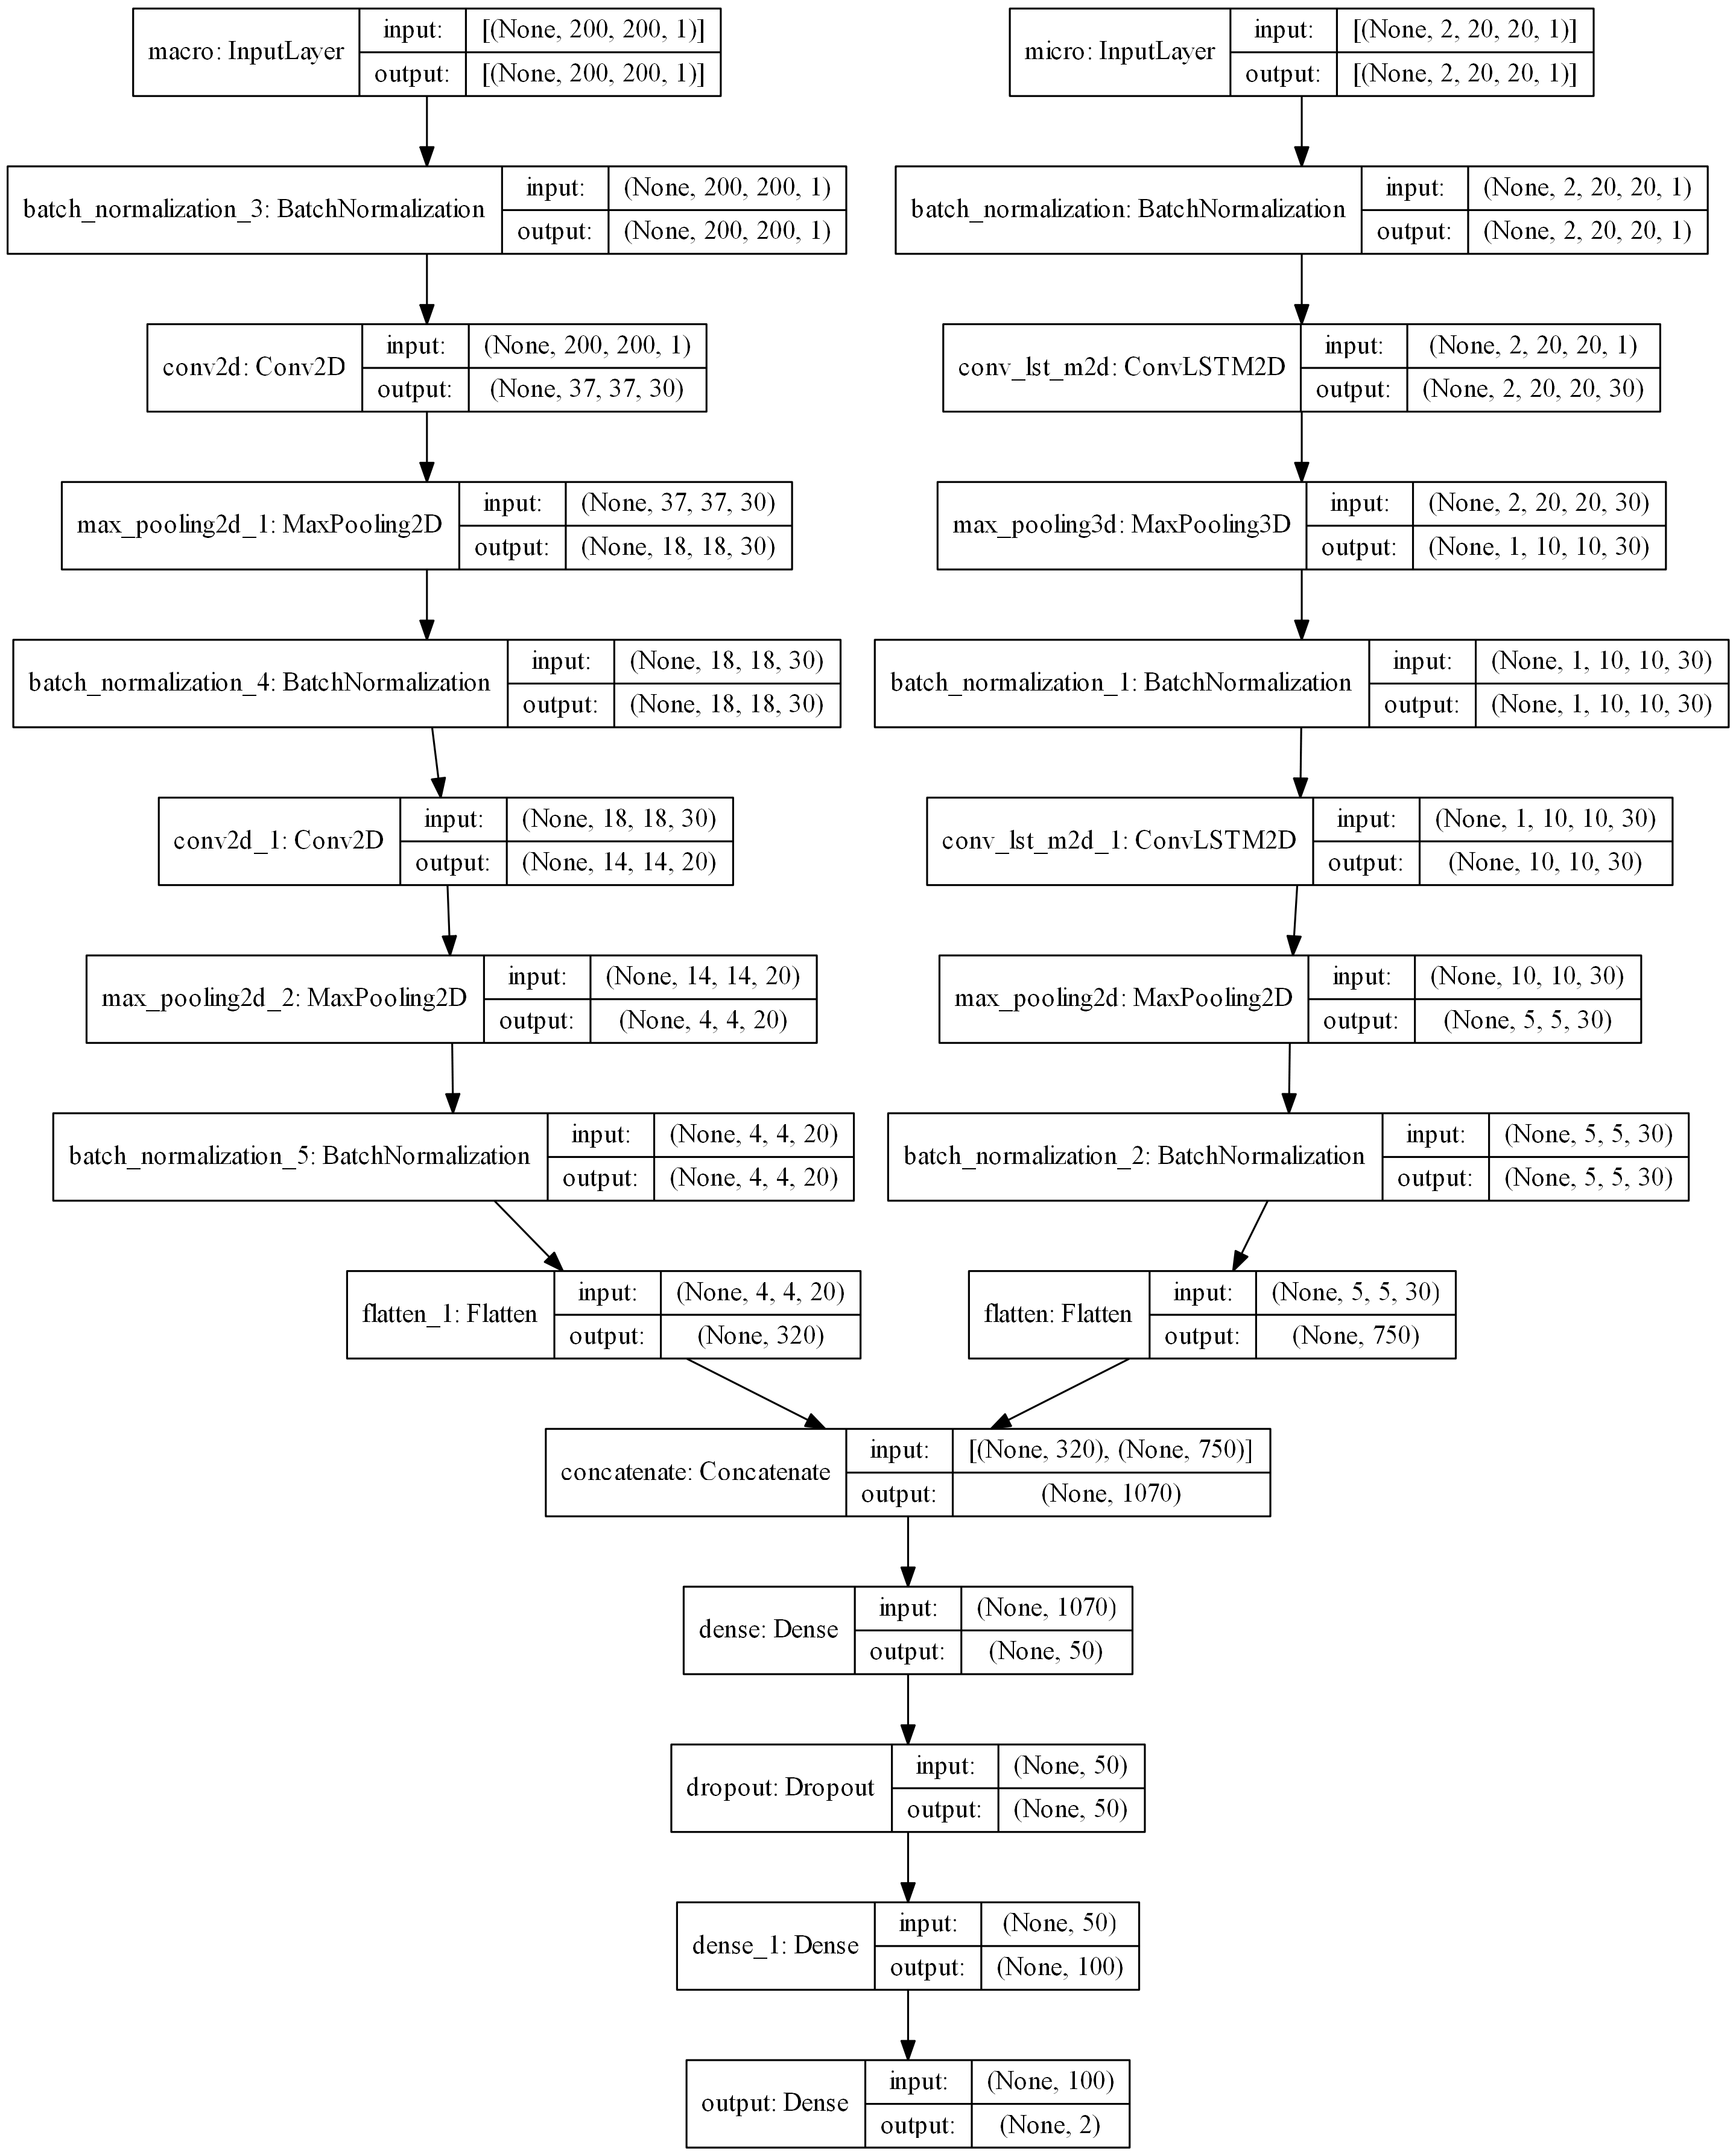

In [19]:
model.compile(
    #     optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    optimizer="adam",
    loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    metrics=["mean_absolute_error", "mean_squared_error"],
)
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, dpi=227)

In [20]:
monitor_param = "val_mean_squared_error"


def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

nan_terminate = tf.keras.callbacks.TerminateOnNaN()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor_param, patience=3)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=monitor_param, patience=5  # , restore_best_weights=True
)

model_dir = os.path.join(data_dir, "model")
checkpoint_filepath = os.path.join(model_dir, "checkpoint")
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor=monitor_param,
    mode="min",
    save_best_only=True,
)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr, checkpoint, nan_terminate],
)

Num GPUs Available:  1
Epoch 1/100


In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
# model_dir = os.path.join(data_dir, "model")
# very_good = os.path.join(model_dir, "around_.16_sq_error_branched_2x_conv")
# model.save(very_good)

In [ ]:
# model.evaluate(x=x_test, y=y_test)
# model.evaluate(test_dataset)

In [ ]:
# preds = model.predict(x=x_test)
# preds = model.predict(x=x_train)
# preds = model.predict(test_dataset)

In [ ]:
# print(preds.shape, y_test.shape)
# print(preds.shape, y_train.shape)

In [ ]:
def unstack(a, axis=1):
    return np.moveaxis(a, axis, 0)


def plot(l, r, preds, labels, width=20, height=7):
    assert len(preds[0].shape) == len(labels[0].shape)
    preds = preds[l:r, :]
    labels = labels[l:r, :]
    preds = unstack(preds)
    labels = unstack(labels)
    x = list(range(len(preds[0])))
    plt.rcParams["figure.figsize"] = [width, height]
    for i, label in enumerate(labels):
        plt.scatter(x, label, label="labels_" + str(i))
    for i, pred in enumerate(preds):
        plt.scatter(x, pred, label="predictions_" + str(i))
    plt.legend()
    plt.show()


# plot(69, 420, preds, y_test)

# making vector fiels
* break up the images in the video
* feed them into the model
* get u and v
* stick u and v onto the picture
* turn the picture into a video?

# how to use the shady vector field code
* for one, it doesn't work right now, something looks flipped or rotated
* but if you want to use it anyways
* train the neural net on the pic size you want to be able to get the vectors out of
* go back up and remake the video into it's full size and length
* run this code

In [ ]:
@njit
def get_sub_pic(pic, x, y, size):
    hs = size // 2
    return pic[:, x - hs : x + hs, y - hs : y + hs, :]


def arrow_data_generator(a, b, xs, ys, macro_size, num_resample):
    for i, (frames, label) in enumerate(zip(a, b)):
        macro = frames
        macro = get_frame(macro, window_size - 1)
        macro = get_center(macro, macro_size)

        for x, y in zip(xs, ys):
            micro = get_sub_pic(frames, x, y, pic_size)

            micro = tf.convert_to_tensor(micro, dtype=tf.float32)
            macro = tf.convert_to_tensor(macro, dtype=tf.float32)
            label = tf.convert_to_tensor(label, dtype=tf.float32)

            yield {"micro": micro, "macro": macro}, label


frames_idx = list(range(0, video.shape[0], 100))
y_arrows = 7
x_arrows = 7
pic_size = output_size


_, _, x_size, y_size, _ = video.shape
x_idx = np.linspace(0, x_size, x_arrows + 2)[1:-1].astype(int)
y_idx = np.linspace(0, y_size, y_arrows + 2)[1:-1].astype(int)

print(y_idx)
print(y_size)


xv, xy = np.meshgrid(x_idx, y_idx)
xs = xv.flatten()
ys = xy.flatten()
x = video[frames_idx]
y = labels[frames_idx]

arrow_gen_dataset = tf.data.Dataset.from_generator(
    arrow_data_generator,
    args=[x, y, xs, ys, macro_size, num_resample],
    output_signature=(
        {
            "micro": tf.TensorSpec(shape=micro_shape, dtype=tf.float32),
            "macro": tf.TensorSpec(shape=macro_shape, dtype=tf.float32),
        },
        tf.TensorSpec(shape=label_shape, dtype=tf.float32),
    ),
).batch(BATCH_SIZE)


uvs = model.predict(arrow_gen_dataset)
uvs = np.split(uvs, len(frames_idx))

plot_dir = os.path.join(data_dir, "plots")

for uv, frame, idx in zip(uvs, x, frames_idx):
    u = uv[:, 1]
    v = uv[:, 0]
    plt.figure(figsize=(7, 7))
    plt.imshow(frame[window_size - 1, :, :, 0], origin="upper")
    plt.quiver(ys, xs, u, v, color="red")
    plt.savefig(os.path.join(plot_dir, "quiver" + str(idx) + ".png"))
    plt.show()


allDone()